# Level 1 vs Level 2 Data:
## A comparison using Modified Normalised Difference Water Index (MNDWI)

* **Products used:** 
[ls8_usgs_sr_scene](https://explorer.digitalearth.africa/ls8_usgs_sr_scene)
* **Level 1 data retrived from:**
[Landsat 8 Level 1 data](https://registry.opendata.aws/landsat-8/) (last accessed 10 July 2020)

## Background
### Analysis-Ready Data (ARD): the difference between Level 1 and Level 2 data

Satellite operators, such as USGS, perform minimal processing on the data before releasing it for general consumption. This is known as **Level 1 data**. As Level 1 data is very close to its raw form, it can be flexibly manipulated by the scientific community, but requires specialist knowledge to use. Atmospheric interference and other underlying satellite data issues must be corrected for before the data shows meaningful results.

The accessibility of available satellite data can therefore be significantly increased by further processing the Level 1 data, such as by applying atmospheric corrections. This processed data is hosted on the OpenDataCube, and is known as **Level 2 data** or **Analysis-Ready Data**, shortened to **ARD**. The corrections improve the overall quality of the data (compared to the Level 1 data) and allow users to conduct analysis independent of expertise in the data corrections process.

### Modified Normalised Difference Water Index (MNDWI)

MNDWI is a variation on the Normalised Difference Water Index (NDWI). NDWI is used to detect the presence of water bodies in remote sensing, and is calculated using the Green band and Near-Infrared (NIR) bands from satellite data.

\begin{equation} \text{NDWI} \ = \ \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}} \end{equation}

However, it has been shown that using a Short-Range Infrared (SWIR) band instead of NIR provides enhanced delineation between water and other types of areas (soil, vegetation, built-up land). This gives the Modified NDWI, or MNDWI.

\begin{equation} \text{MNDWI} \ = \ \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}} \end{equation}

In the case of Landsat 8 satellite data, which has two SWIR bands, SWIR 1 is used. The indices are normalised, which means their values range from -1 to 1. Generally, this can be interpreted as:

* MNDWI $> 0$ : water
* MNDWI $\leq 0$ : soil, vegetation, urban areas

## Description

This notebook will show the ARD (Level 2) produces better results than uncorrected (Level 1) data. This is done by calculating MNDWI using Level 1 data and Level 2 data from Landsat 8, for the same region. The results show the ARD data shows clearer signals and more defined patterns. This is particularly noticeable at the edges of water bodies, where the ARD displays visibly distinct waterlines compared to the Level 1 data.

The notebook contains the following steps:
1. Fulfill prerequisites: select a location for analysis and download Level 1 data.
2. Load Level 1 data for the location.
3. Load Level 2 data for the location.
4. Calculate MNDWI for the Level 1 data.
5. Calculate MNDWI for the Level 2 data.
6. Compare the Level 1 and Level 2 data by plotting them together.
7. Zoom in on waterlines to show difference in clarity between datasets.

*****

## Getting Started
To run this analysis, ensure the prerequesites are fulfilled, then run all the cells in the notebook, starting with the "Load packages" cell. 

### Prerequisites

The Digital Earth Africa (DE Africa) sandbox does not index Landsat 8 Level 1 data. This means Level 1 data must be manually downloaded from the USGS website before it can be imported into the notebook. A time and place for analysis must be decided.

* Choosing location

For the purposes of this notebook, a mix of water and land areas is desireable. An area off the coast of Guinea Bissau, Senegal, has been selected. This is centred around the following coordinates:

`lat = 11.228`<br>
`lon = -15.860`

* Choosing time

Here, MNDWI is calculated for a single instance in time. The period of time chosen for this notebook was `January 2018`. Fortuitously, there is only one "scene" (satellite flyover) for the chosen location during the month of January 2018. If there were multiple flyovers, only one would have been selected.

* Downloading Level 1 data

*Note: this requires an active Amazon Web Services (AWS) account.*

The time and place can now be searched on the [DE Africa Metadata Explorer](https://explorer.digitalearth.africa/ls8_usgs_sr_scene). If not preselected, the selected product should be `ls8_usgs_sr_scene`. Use the `Year` and `Month` dropdowns to select `2018` and `January` as appropriate.

By browsing the `Day` dropdown, the only scene encapsulating the Bissau coast is `9 January 2018`. Click `11 datasets available` on the right-hand toolbar to open details of each scene taken on that day. The datasets are separated by location; the Bissau coast is the last dataset: [13b9c5f0-65f0-5d2e-8473-5bbfc92a9673](https://explorer.digitalearth.africa/dataset/13b9c5f0-65f0-5d2e-8473-5bbfc92a9673). Note this code; it is the `Scene ID` and will be needed later for datacube imports. Note the `Locations > Active:` field as it shows the naming convention for this scene.

Navigate to the [USGS Landsat 8 registry](https://registry.opendata.aws/landsat-8/) and access their AWS S3 Bucket. The file naming convention is the same as the `Locations > Active` field in the DE Africa Explorer; i.e. look for a folder starting with `LC08_L1TP_204052_20180109_20180119_01_T1`. 

The folder for this scene will contain many files. Download the Band 3 `_B3` and Band 6 `_B6` `.tiff` files locally and upload them to the same Jupyterlab folder as this notebook. This can be done by clicking the `Upload files` button on the horizontal toolbar options in the sandbox File Browser.


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
from datacube.testutils import io
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xarray as xr
import numpy as np

sys.path.append("../Scripts")
from deafrica_bandindices import calculate_indices

### Connect to the datacube
Connect to the datacube so we can access DE Africa data. The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="L1_L2_MNDWI_Comparison")

## Load required datasets

### Load Level 1 data - from file
The file suffix `B3` indicates Band 3, the Landsat 8 Green band. Likewise, `B6` is Band 6, the Landsat 8 SWIR 1 band. The `tiff` files uploaded to the sandbox can be imported as `xarray` DataArrays, and then combined into a DataSet.

In [3]:
l1_green = io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B3.tiff')
l1_swir1 =  io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B6.tiff')

In [4]:
# Create a DataSet named 'l1_data' and add to it the DataArrays 'green' and 'swir1'.
l1_data = l1_green.to_dataset(name = 'green')
l1_data['swir1'] = l1_swir1
l1_data

<xarray.Dataset>
Dimensions:      (x: 7601, y: 7761)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    swir1        (y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0

### Load Level 2 data - from datacube

To match the Level 1 data, we want to import the same scene from the Level 2 data hosted in the datacube. This can be done by specifying the exact scene using the `Scene ID` field from the DE Africa Metadata Explorer. See the *Prerequisites* section above. 

Since we only need the Green band and SWIR 1 band to calculate MNDWI, we can specify the query to load those only. 

In [5]:
# Show all datacube products
#dc.list_products()

# Specify product, scene and measurements to load
query = {}
query['product'] = 'ls8_usgs_sr_scene'
query['id'] = '13b9c5f0-65f0-5d2e-8473-5bbfc92a9673'
query['measurements'] = ['green','swir1']

# Check the scene matches the L1 scene
ds_l2 = dc.find_datasets(**query)

# Specify output CRS and resolution
query['output_crs'] = ds_l2[0].metadata_doc['grid_spatial']['projection']['spatial_reference']
query['resolution'] = (-30,30)
query['align'] = (15,15)

# Load the L2 data using the parameters specified in the query
l2_data = dc.load(**query)
l2_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 7601, y: 7761)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir1        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

In [100]:
flat[500]

-9999

In [101]:
# test cell. To count how many -9999 s there are in the data (ie those NaN corners)

blank = 0
flat = l2_data.green.values.ravel()
for i in range(len(flat)):
    if flat[i] == -9999:
        blank = blank + 1
print(blank)

18484045


There is a 1-pixel offset between the Level 1 and Level 2 data. This can be determined by removing the query running the command below.
It checks if both datasets have the same `x` values, and without the `query['align']` parameter in the previous cell, it will return a mismatch error. 

The error shows an offset of 15 metres in each `x` value. This originates from the L2 data coordinates being at the corner of the cell, while L1 data places them in the centre. Therefore, this offset can be corrected by using `'align'` and specifying the 15 m by 15 m offset.

In [6]:
# Check if the x values of the datasets match
#np.testing.assert_allclose(l1_data['x'].values, l2_data.x.values)

## Calculate MNDWI

MNDWI can be calculated using the pre-loaded `calculate_indices` function. It can alternatively be defined by the user - an example is shown below. In either case, `MNDWI` is added as a `Data variable` to the DataSet it is calculated for.

### Example: define your own MNDWI calculation
Future calls for `calculate_indices()` can be replaced with `calculate_mndwi(lx_data)`, where `x = 1` or `2`, corresponding to the names of the Level 1 and Level 2 datasets.

In [7]:
def calculate_mndwi(dc):
    dc['MNDWI'] = (dc.green - dc.swir1)/(dc.green + dc.swir1)
    return(dc)

The cells below use the standard DE Africa `calculate_indices` function, which require a few extra parameters. `index` defines the index to be calculated (in our case, MNDWI) and `c1` refers to Collection 1 of the DE Africa datacube products. At time of writing, only Collection 1 is available for general use.

### Level 1 MNDWI
The `fillna(0)` command sets all Not a Numbers (NaNs) to 0, to match the Level 2 data.

In [71]:
l1_data = calculate_indices(l1_data, index = 'MNDWI', collection = 'c1') 
l1_data = l1_data.fillna(0)
#l1_data

### Level 2 MNDWI

In [9]:
l2_data = calculate_indices(l2_data, index = 'MNDWI', collection = 'c1')
#l2_data

## Plot MNDWI

### Whole-scene plots

Subplots can be used to show the Level 1 and Level 2 MNDWIs side by side. Note the entire scene is fairly large (more than 7000 x 7000 pixels!) so the `figsize` dimensions cannot be too small or the data will not show.

*Note: this plot can cause the kernel to crash. If so, select* `Kernel > Restart Kernel and Run All Cells...` *to obtain the plot. The plot code can then be commented out using # to prevent overloading memory.*

In [10]:
# fig1, ax = plt.subplots(1, 2, figsize=(28,13))
# fig1.suptitle("MNDWI Comparison: Level 1 and Level 2 Data", size = 25)

# # squeeze() collapses any single-dimensional entries from the array
# # In this case, the data contains only a single timestep, so squeeze() collapses that

# l1_data.squeeze().MNDWI.plot(ax=ax[0], cmap='RdBu', vmin=-1, vmax=1)
# ax[0].set_title('Level 1 MNDWI', size = 20)

# l2_data.squeeze().MNDWI.plot(ax=ax[1], cmap='RdBu', vmin=-1, vmax=1)
# ax[1].set_title('Level 2 MNDWI', size = 20)

### Waterline close-ups

The improvements provided by Level 2 data can be best exemplified by looking closer at a region where water meets land. We will look at the estuaries of the river Rio Baboque at two different scales.

In [11]:
# Rio Baboque x and y coordinates

zoomed_xmin = 388000
zoomed_xmax = 403000
zoomed_ymin = 1323000
zoomed_ymax = 1338000

#Note in the DataSet structure, y values are listed in decreasing order, so the ymax is listed first when performing a slice() command in the y dimension

Text(0.5, 1.0, 'Level 2 MNDWI')

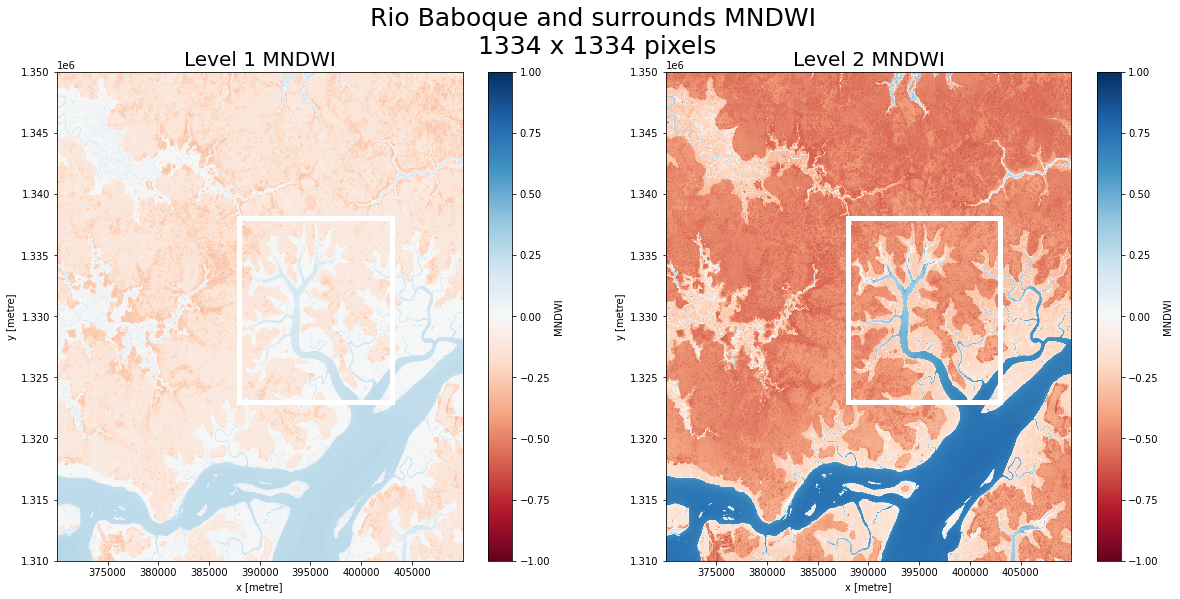

In [12]:
fig2, ax = plt.subplots(1, 2, figsize=(20, 9))
fig2.suptitle("Rio Baboque and surrounds MNDWI \n1334 x 1334 pixels", size = 25)

l1_data.MNDWI.sel(x = slice(370000, 410000), y = slice(1350000,1310000)).plot(ax = ax[0], cmap='RdBu', vmin=-1, vmax=1)
selection = patches.Rectangle((zoomed_xmin, zoomed_ymin), 15000, 15000, linewidth = 5, edgecolor = 'w', facecolor = 'none')
ax[0].add_patch(selection)
ax[0].set_title('Level 1 MNDWI', size = 20)

l2_data.MNDWI.sel(x = slice(370000, 410000), y = slice(1350000,1310000)).plot(ax = ax[1], cmap='RdBu', vmin=-1, vmax=1)
selection = patches.Rectangle((zoomed_xmin, zoomed_ymin), 15000, 15000, linewidth = 5, edgecolor = 'w', facecolor = 'none')
ax[1].add_patch(selection)
ax[1].set_title('Level 2 MNDWI', size = 20)

Text(0.5, 1.0, 'Level 2 MNDWI')

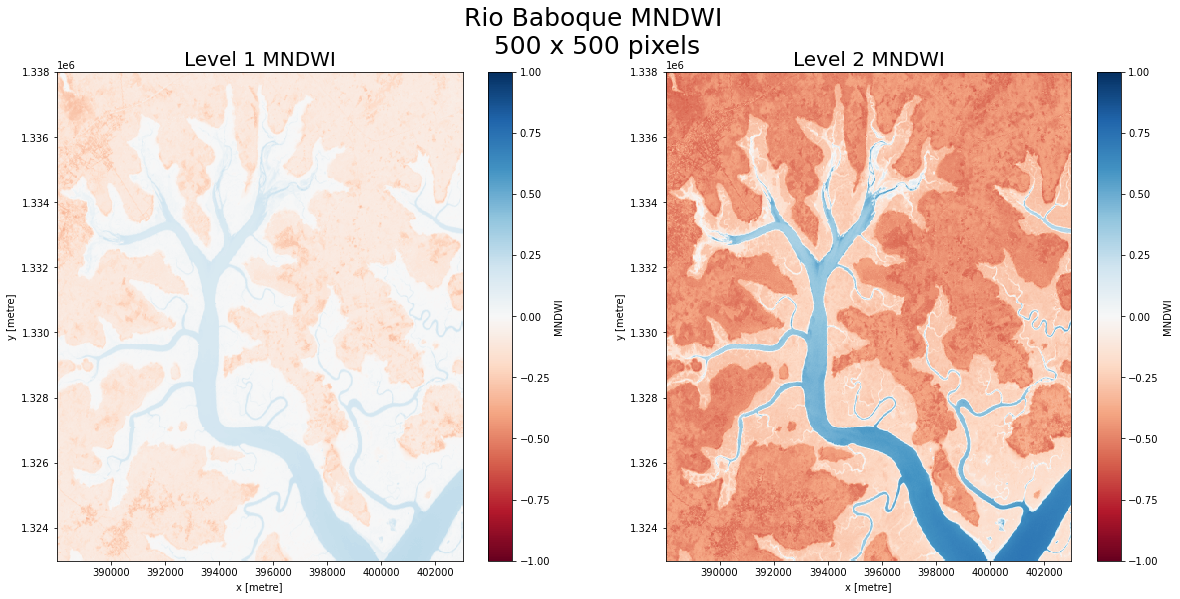

In [13]:
fig3, ax = plt.subplots(1, 2, figsize=(20, 9))
fig3.suptitle("Rio Baboque MNDWI \n500 x 500 pixels", size = 25)

l1_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[0], cmap='RdBu', vmin=-1, vmax=1)
ax[0].set_title('Level 1 MNDWI', size = 20)

l2_data.MNDWI.sel(x = slice(zoomed_xmin, zoomed_xmax), y = slice(zoomed_ymax, zoomed_ymin)).plot(ax=ax[1], cmap='RdBu', vmin=-1, vmax=1)
ax[1].set_title('Level 2 MNDWI', size = 20)

## Analysis

Visually, the above plots favour the Level 2 data. Using the same MNDWI scale, the landscape features are clearer. However, there are some considerations that 

* The threshold for L1 data needs to be adjusted; likely it will have to be adjusted for every different scene. L2 uses surface reflectance so it can be thresholded at 0 with not too many ill effects?
* The L1 data is more affected by non-permanent 


### Reflectance distribution profiles

The MNDWI values can be plotted by frequency for the Rio Baboque area.

In [57]:
#l1_data.MNDWI.plot.hist(bins=100, figsize=(10,10))
#len(l1_data.to_array().values.ravel())

test1 = l1_data.drop_vars('green')
test1 = test1.drop_vars('swir1')
test1 = test1.to_array()
test1 = test1.values.ravel()
len(test1)

58991361

In [39]:
7601*7761

58991361

<Figure size 720x720 with 0 Axes>

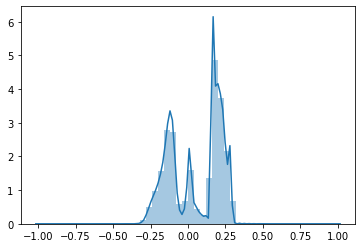

<Figure size 720x720 with 0 Axes>

In [62]:
import seaborn as sns

sns.distplot(test1[test1 != 0])
plt.figure(figsize = (10,10))

In [65]:
# How many zeros in the Level 1 dataset
len(test1) - np.count_nonzero(test1)

17573265

In [66]:
test2 = l2_data.drop_vars('green')
test2 = test2.drop_vars('swir1')
test2 = test2.to_array()
test2 = test2.values.ravel()
len(test2)

58991361

<Figure size 720x720 with 0 Axes>

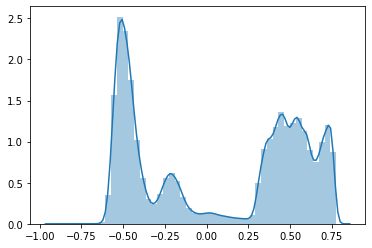

<Figure size 720x720 with 0 Axes>

In [67]:
sns.distplot(test2[test2 != 0])
plt.figure(figsize = (10,10))

In [68]:
# How many zeros in the Level 2 dataset
len(test2) - np.count_nonzero(test2)

18486882

### Robustness over time

Find another time of the same scene; compare a likely-to-not-have-changed body of water and see how much L1 vs L2 has changed

## Conclusions

It is clear when calculating MNDWI, the Level 2 data is much more suitable. This could be due to several factors:

* L1 data is not suitable for calculating MNDWI: this might sound like a redundant statement, but the extra processing of L2

### Level 2 data is better for calculating indices that use 

MNDWI is conventionally used to show the 

### Level 2 data is more user-friendly

***

**Acknowledgements:** Thank you to Caitlin, Chad, Dave, Alex and Kirill.

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible `datacube` version:** 

In [14]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02
